<a href="https://colab.research.google.com/github/Squbaany/Neuronki/blob/main/Neronki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobieranie danych z kaggle https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images

In [5]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

import zipfile
zip_ref = zipfile.ZipFile('cifake-real-and-ai-generated-synthetic-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 99% 103M/105M [00:00<00:00, 141MB/s] 
100% 105M/105M [00:00<00:00, 127MB/s]


In [6]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from IPython.display import Image

Sprawdzenie czy keras wykrywa karte graficzna

In [7]:
print("Devices: ", tf.config.list_physical_devices())

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Utworzenie zbiorow z pobranych danych

In [8]:
datasetPath = "/content"

imgHeight = 32
imgWidth = 32
batchSize = 512

trainingSet = tf.keras.utils.image_dataset_from_directory(
    datasetPath + "/train",
    seed = 512,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

testingSet = tf.keras.utils.image_dataset_from_directory(
    datasetPath + "/test",
    seed = 512,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

print("Training classes: ", trainingSet.class_names)
print("Testing classes: ", testingSet.class_names)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Training classes:  ['FAKE', 'REAL']
Testing classes:  ['FAKE', 'REAL']


In [9]:
def plotMetrics(history, metric):
    plt.plot(history.history[metric], label = metric)
    plt.plot(history.history['val_' + metric], label='val_' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

trueClasses = np.concatenate([y for x, y in testingSet], axis = 0)
classNames = ['FAKE', 'REAL']
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

In [10]:
VGG16_base = tf.keras.applications.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (imgHeight, imgWidth, 3),
    pooling = "max"
)

VGG16_base.trainable = True

input = tf.keras.Input(shape = (imgHeight, imgWidth, 3))
conf = VGG16_base(input, training = False)
conf = BatchNormalization(
    axis = -1,
    momentum = 0.99,
    epsilon = 0.001)(conf)
conf = Dense(
    256,
    kernel_regularizer = regularizers.l2(0.01),
    activity_regularizer = regularizers.l1(0.01),
    bias_regularizer = regularizers.l1(0.01),
    activation = "relu")(conf)
conf = Dropout(
    rate = .4,
    seed = 512)(conf)
conf = Dense(
    64,
    activation="relu")(conf)
output = Dense(1, activation = "sigmoid")(conf)

VGG16_model = tf.keras.Model(input, output)

VGG16_model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = .001), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

VGG16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448  

In [11]:
print("Starting trainging at", datetime.now())
VGG16_history = VGG16_model.fit(
    trainingSet,
    validation_data = testingSet,
    epochs = 100,
    verbose = 1,
    callbacks = [early_stopping]
)
print("Finished trainging at", datetime.now())
VGG16_model.save("VGG16-1-gen.keras")
print("Saved trained model")

Starting trainging at 2024-04-24 11:45:44.078894
Epoch 1/100
196/196 [==============================] - 61s 193ms/step - loss: 1.4417 - accuracy: 0.7843 - precision: 0.7654 - recall: 0.8198 - val_loss: 1.5906 - val_accuracy: 0.5177 - val_precision: 0.5090 - val_recall: 1.0000
Epoch 2/100
196/196 [==============================] - 34s 171ms/step - loss: 0.3270 - accuracy: 0.9247 - precision: 0.9232 - recall: 0.9265 - val_loss: 0.7602 - val_accuracy: 0.6560 - val_precision: 0.5924 - val_recall: 0.9996
Epoch 3/100
196/196 [==============================] - 34s 170ms/step - loss: 0.2074 - accuracy: 0.9427 - precision: 0.9438 - recall: 0.9416 - val_loss: 0.6767 - val_accuracy: 0.7106 - val_precision: 0.6335 - val_recall: 0.9992
Epoch 4/100
196/196 [==============================] - 34s 171ms/step - loss: 0.1655 - accuracy: 0.9518 - precision: 0.9530 - recall: 0.9505 - val_loss: 0.1565 - val_accuracy: 0.9516 - val_precision: 0.9454 - val_recall: 0.9585
Epoch 5/100
196/196 [==================

In [ ]:
loadedModel = tf.keras.saving.load_model("VGG16-1-gen.keras")

40/40 [==============================] - 2s 48ms/step - loss: 0.1199 - accuracy: 0.9641 - precision: 0.9619 - recall: 0.9665
Loss: 0.1199
Accuracy: 0.9641
Precision: 0.9619
Recall: 0.9665


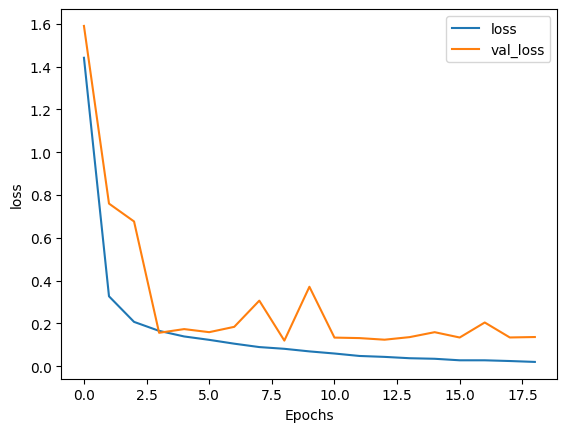

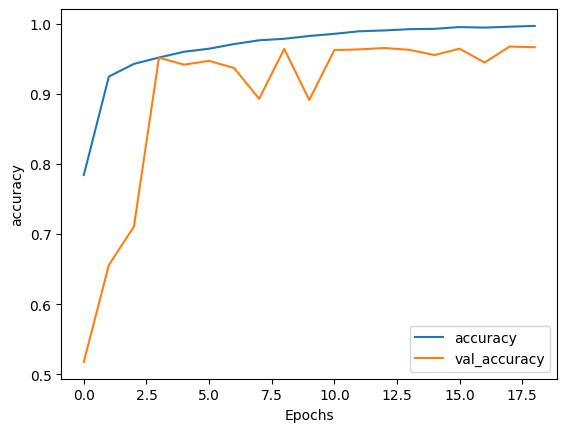

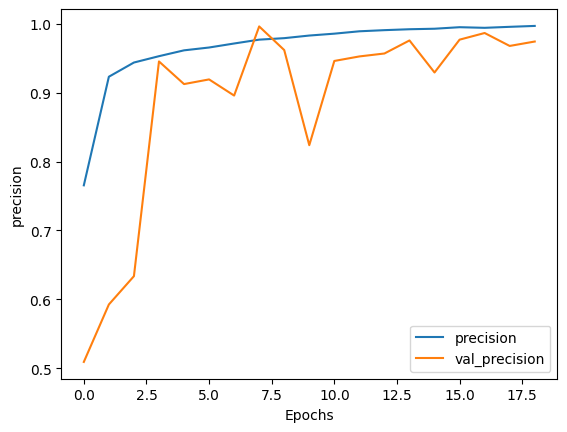

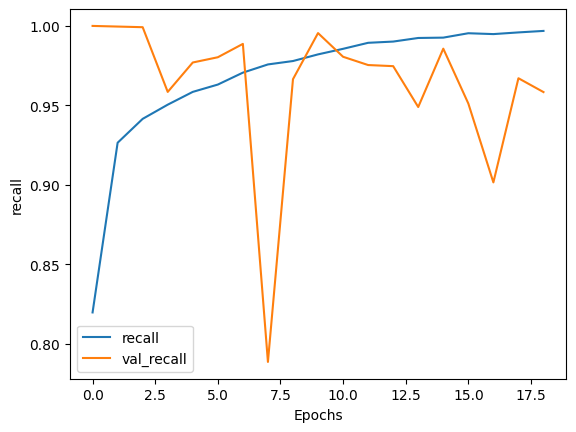

In [13]:
val_loss, val_accuracy, val_precision, val_recall = loadedModel.evaluate(testingSet)

print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

plotMetrics(loadedModel, "loss")
plotMetrics(loadedModel, "accuracy")
plotMetrics(loadedModel, "precision")
plotMetrics(loadedModel, "recall")